In [ ]:
# 1. ИМПОРТ БИБЛИОТЕК
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os

# Визуализация
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import plot

# Машинное обучение (для кластеризации в RFM)
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import (
    StandardScaler,
    FunctionTransformer,
    LabelEncoder,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
    QuantileTransformer
)

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
from statsmodels.tsa.arima.model import ARIMA



In [62]:
# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [63]:
'''1. Загрузка данных'''
merged_cleaned_data = pd.read_csv('11_merged_cleaned_data.csv')

In [64]:
df = merged_cleaned_data

Корреляционный анализ

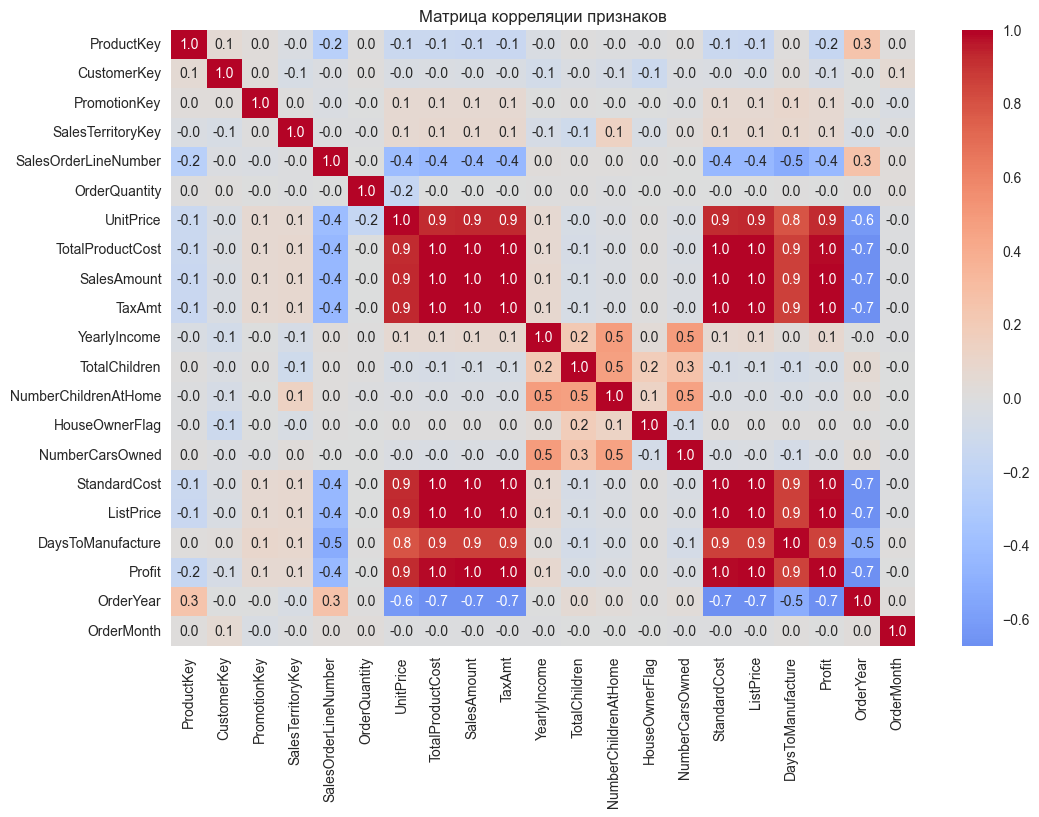

✅ Корреляционный анализ завершён


In [65]:
# Убедимся, что все числовые столбцы
numeric_df = df.select_dtypes(include=[float, int])

# Корреляционная матрица
correlation_matrix = numeric_df.corr()

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap='coolwarm', center=0)
plt.title('Матрица корреляции признаков')
plt.show()

print("✅ Корреляционный анализ завершён")

In [66]:
# Найдём признаки с корреляцией > 0.7
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                    correlation_matrix.columns[j], 
                                    correlation_matrix.iloc[i, j]))

print("⚠️ Сильно коррелирующие пары:")
for pair in high_corr_pairs:
    print(f"   • {pair[0]} и {pair[1]}: {pair[2]:.2f}")

⚠️ Сильно коррелирующие пары:
   • UnitPrice и TotalProductCost: 0.93
   • UnitPrice и SalesAmount: 0.93
   • UnitPrice и TaxAmt: 0.93
   • UnitPrice и StandardCost: 0.93
   • UnitPrice и ListPrice: 0.93
   • UnitPrice и DaysToManufacture: 0.80
   • UnitPrice и Profit: 0.92
   • TotalProductCost и SalesAmount: 1.00
   • TotalProductCost и TaxAmt: 1.00
   • TotalProductCost и StandardCost: 1.00
   • TotalProductCost и ListPrice: 1.00
   • TotalProductCost и DaysToManufacture: 0.86
   • TotalProductCost и Profit: 0.99
   • SalesAmount и TaxAmt: 1.00
   • SalesAmount и StandardCost: 1.00
   • SalesAmount и ListPrice: 1.00
   • SalesAmount и DaysToManufacture: 0.86
   • SalesAmount и Profit: 1.00
   • TaxAmt и StandardCost: 1.00
   • TaxAmt и ListPrice: 1.00
   • TaxAmt и DaysToManufacture: 0.86
   • TaxAmt и Profit: 1.00
   • StandardCost и ListPrice: 1.00
   • StandardCost и DaysToManufacture: 0.86
   • StandardCost и Profit: 0.99
   • ListPrice и DaysToManufacture: 0.86
   • ListPrice и

стандартизация нормализация  признаков

In [67]:
# StandardScaler
# Убедимся, что 'OrderDate' — формат datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

# Максимальная дата в данных — это "сегодня"
snapshot_date = df['OrderDate'].max()

# Удаляем старый Recency, если он есть
if 'Recency' in df.columns:
    df = df.drop(columns=['Recency'])

# Группируем по CustomerKey и считаем Recency (дней с последнего заказа)
recency_data = df.groupby('CustomerKey').agg({
    'OrderDate': lambda x: (snapshot_date - x.max()).days
}).reset_index()

recency_data.columns = ['CustomerKey', 'Recency']

# Объединяем с основным DataFrame
df = df.merge(recency_data, on='CustomerKey', how='left')

# Создаём столбец Churn
df['Churn'] = (df['Recency'] > 300).astype(int)

# Выбираем только числовые столбцы
numeric_df = df.select_dtypes(include=[np.number])

# Удаляем CustomerKey и Churn из numeric_df, если они там есть
if 'CustomerKey' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['CustomerKey'])
if 'Churn' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['Churn'])

# Применяем StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Преобразуем обратно в DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns, index=numeric_df.index)

print("\n✅ Данные нормализованы с помощью StandardScaler.")
print("Первые 5 строк нормализованных данных:")
print(scaled_df.head())

# Объединяем scaled_df с CustomerKey и Churn
df_features = df[['CustomerKey', 'Churn']].copy()
df_features = df_features.join(scaled_df)

print("\n✅ Подготовка признаков завершена.")


✅ Данные нормализованы с помощью StandardScaler.
Первые 5 строк нормализованных данных:
   ProductKey  PromotionKey  SalesTerritoryKey  SalesOrderLineNumber  \
0   -1.077135     -0.124453          -0.088411             -0.871059   
1   -0.772306     -0.124453           0.249401             -0.871059   
2   -0.772306     -0.124453          -1.777473             -0.871059   
3   -0.856980     -0.124453          -0.764036             -0.871059   
4   -0.772306     -0.124453           0.925026             -0.871059   

   OrderQuantity  UnitPrice  TotalProductCost  SalesAmount    TaxAmt  \
0       0.411078   1.650866          3.346781     3.265801  3.265801   
1       0.411078   1.543861          2.884169     3.076434  3.076434   
2       0.411078   1.543861          2.884169     3.076434  3.076434   
3       0.411078  -0.077234          0.208165     0.207585  0.207586   
4       0.411078   1.543861          2.884169     3.076434  3.076434   

   YearlyIncome  TotalChildren  NumberChildre

Обучение

Логарифмическая регрессия 

In [68]:
# Подготовка признаков и целевой переменной
X = df_features.drop(['CustomerKey', 'Churn'], axis=1)  # признаки
y = df_features['Churn']  # целевая переменная

# Применяем SMOTE (только к обучающей выборке!)
smote = SMOTE(random_state=23423)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=43, stratify=y_resampled
)

print('Размеры тренировочной выборки X:', len(X_train))
print('Размеры тестовой выборки X:', len(X_test))
print('Размеры тренировочной выборки y:', len(y_train))
print('Размеры тестовой выборки y:', len(y_test))

# Обучение модели
model = LogisticRegression(
    max_iter=10000, penalty='l2', tol=0.001, solver='lbfgs', C=0.7, random_state=42
)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # вероятности класса 1

# Оценка
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nТочность модели: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nКлассификационный отчёт:")
print(classification_report(y_test, y_pred))

Размеры тренировочной выборки X: 85155
Размеры тестовой выборки X: 21289
Размеры тренировочной выборки y: 85155
Размеры тестовой выборки y: 21289

Точность модели: 0.9949
AUC-ROC: 1.0000

Классификационный отчёт:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10645
           1       0.99      1.00      0.99     10644

    accuracy                           0.99     21289
   macro avg       0.99      0.99      0.99     21289
weighted avg       0.99      0.99      0.99     21289



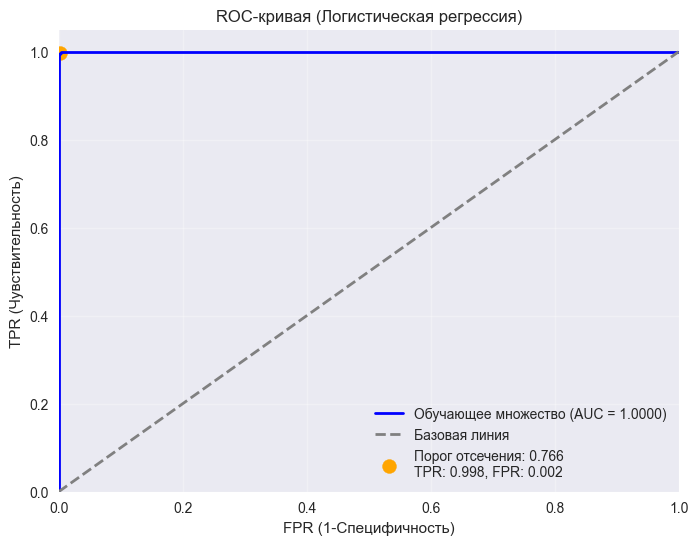


✅ Оптимальный порог отсечения: 0.766


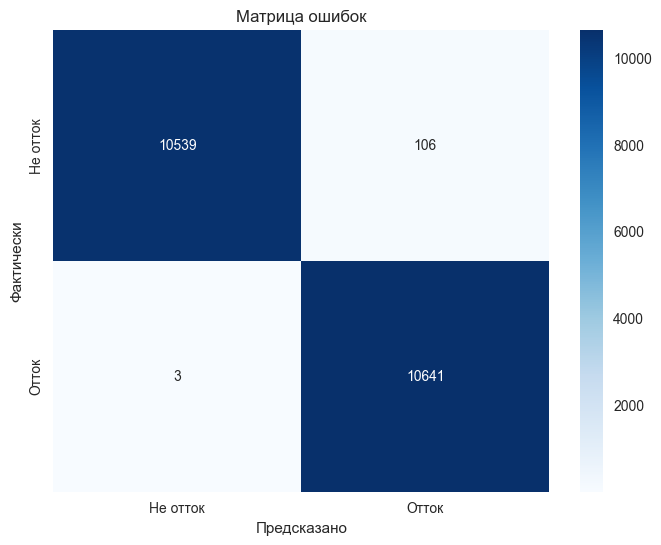


📊 Таблица метрик:
  Метрика  Значение
  AUC ROC  0.999950
Precision  0.990137
   Recall  0.999718
 F1 Score  0.994904
      MCC  0.989806

📈 Распознано:
   • Обучающее: 21180/85155 (24.9%)
   • Тестовое: 21180/21289 (99.5%)

🧾 Матрица ошибок (в процентах):
                      Классифицировано: Не отток  Классифицировано: Отток
Фактически: Не отток                        99.0                      1.0
Фактически: Отток                            0.0                    100.0


In [69]:
# --- График ROC-кривой ---
plt.figure(figsize=(8, 6))

# Рассчитываем TPR и FPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Построение ROC-кривой
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Обучающее множество (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Базовая линия')

# Находим оптимальный порог (максимум Youden's J = TPR - FPR)
j_scores = tpr - fpr
best_threshold = thresholds[j_scores.argmax()]
best_tpr = tpr[j_scores.argmax()]
best_fpr = fpr[j_scores.argmax()]

# Отмечаем оптимальный порог
plt.scatter(best_fpr, best_tpr, color='orange', s=100, label=f'Порог отсечения: {best_threshold:.3f}\nTPR: {best_tpr:.3f}, FPR: {best_fpr:.3f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (1-Специфичность)')
plt.ylabel('TPR (Чувствительность)')
plt.title('ROC-кривая (Логистическая регрессия)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✅ Оптимальный порог отсечения: {best_threshold:.3f}")

# --- Матрица ошибок ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не отток', 'Отток'], 
            yticklabels=['Не отток', 'Отток'])
plt.title('Матрица ошибок')
plt.xlabel('Предсказано')
plt.ylabel('Фактически')
plt.show()

# --- Таблица метрик ---
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

metrics_data = {
    'Метрика': ['AUC ROC', 'Precision', 'Recall', 'F1 Score', 'MCC'],
    'Значение': [
        roc_auc_score(y_test, y_pred_proba),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        matthews_corrcoef(y_test, y_pred)
    ]
}

metrics_df = pd.DataFrame(metrics_data)
print("\n📊 Таблица метрик:")
print(metrics_df.to_string(index=False))

# --- Распознано (True Positives / Total) ---
tp = cm[1, 1]  # True Positive
tn = cm[0, 0]  # True Negative
fp = cm[0, 1]  # False Positive
fn = cm[1, 0]  # False Negative

total_test = len(y_test)
total_train = len(y_train)

print("\n📈 Распознано:")
print(f"   • Обучающее: {tp + tn}/{total_train} ({(tp + tn)/total_train*100:.1f}%)")
print(f"   • Тестовое: {tp + tn}/{total_test} ({(tp + tn)/total_test*100:.1f}%)")

# --- Дополнительно: Таблица "Фактически vs Классифицировано" ---
print("\n🧾 Матрица ошибок (в процентах):")
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent_df = pd.DataFrame(
    cm_percent,
    index=['Фактически: Не отток', 'Фактически: Отток'],
    columns=['Классифицировано: Не отток', 'Классифицировано: Отток']
)
print(cm_percent_df.round(1))

Линейная регрессия 

In [76]:
# Целевая переменная (например, SalesAmount)
y = df['SalesAmount']

# Признаки (как вы указали)
features = [
    'UnitPrice', 'SubCategory', 'Category', 'DaysToManufacture', 'Gender', 
    'YearlyIncome', 'TotalChildren', 'Education', 'Occupation', 
    'HouseOwnerFlag', 'NumberCarsOwned', 'CommuteDistance', 
    'CustomerCity', 'CustomerState', 'Region', 'Country'
]

X = df[features].copy()

# Кодируем категориальные признаки
label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

# Нормализуем числовые признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка
r2 = r2_score(y_test, y_pred)

print(f"Коэффициент детерминации (R²): {r2:.4f}")

Коэффициент детерминации (R²): 0.8968


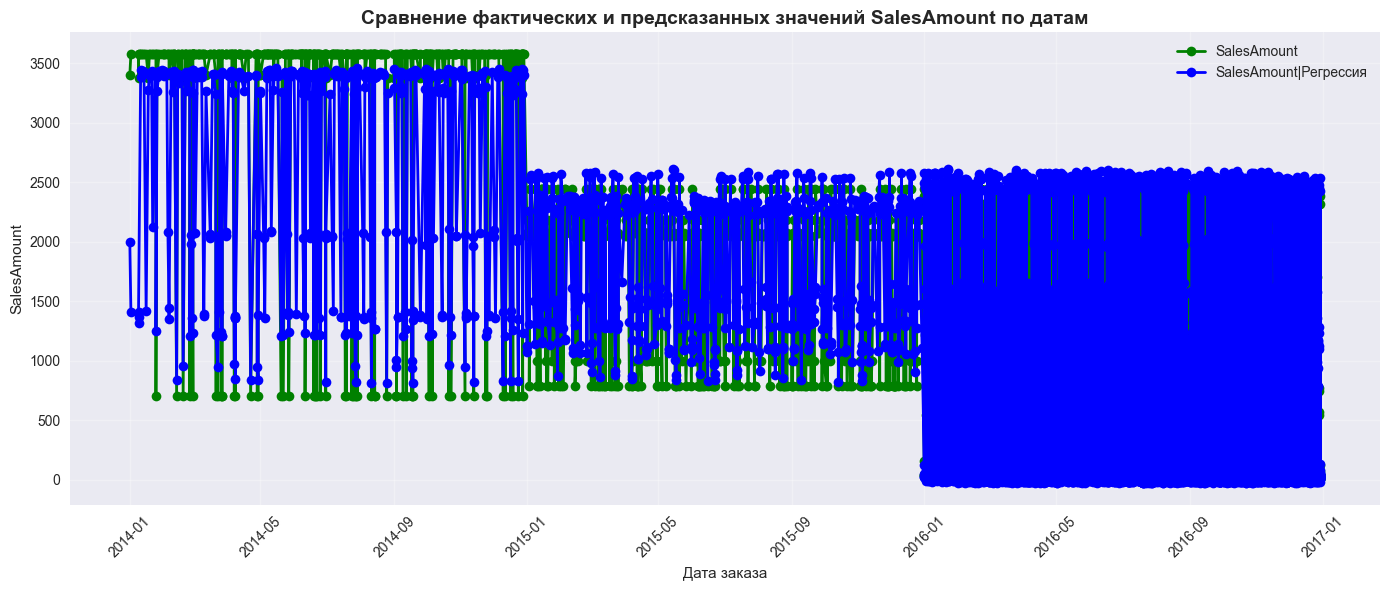

✅ График: Фактические vs Предсказанные значения SalesAmount по датам


In [71]:
# Создаём DataFrame для графика
plot_data = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred,
    'Date': df.loc[X_test.index, 'OrderDate'].reset_index(drop=True)  # берем даты из исходного df по индексу X_test
})

# Сортируем по дате (если нужно)
plot_data = plot_data.sort_values('Date').reset_index(drop=True)

plt.figure(figsize=(14, 6))

# Фактические значения
plt.plot(plot_data['Date'], plot_data['Actual'], 
         marker='o', color='green', linewidth=2, label='SalesAmount')

# Предсказанные значения
plt.plot(plot_data['Date'], plot_data['Predicted'], 
         marker='o', color='blue', linewidth=2, label='SalesAmount|Регрессия')

plt.title('Сравнение фактических и предсказанных значений SalesAmount по датам', fontsize=14, fontweight='bold')
plt.xlabel('Дата заказа')
plt.ylabel('SalesAmount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # поворот дат, чтобы не накладывались

plt.tight_layout()
plt.show()

print("✅ График: Фактические vs Предсказанные значения SalesAmount по датам")

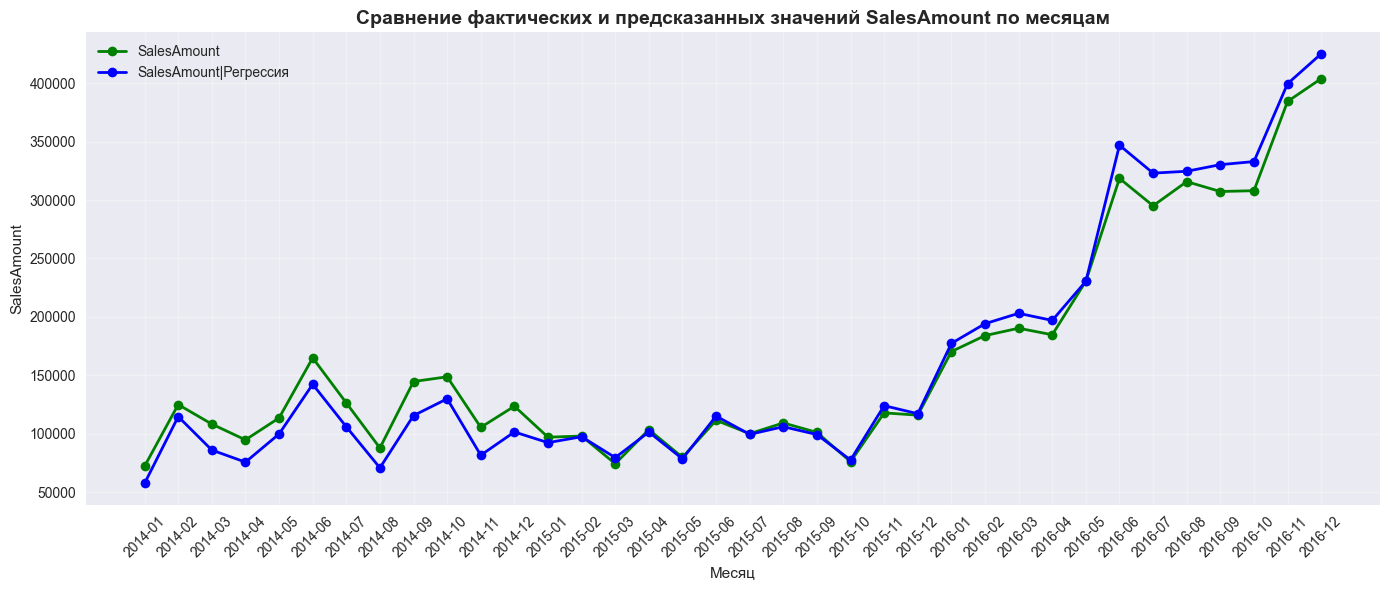

✅ График: Фактические vs Предсказанные значения SalesAmount по месяцам


In [77]:
# Построение графика по месяцам (OrderMonth)

# Создаём DataFrame для графика
plot_data = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred,
    'OrderMonth': df.loc[X_test.index, 'OrderMonth'].reset_index(drop=True),
    'OrderYear': df.loc[X_test.index, 'OrderYear'].reset_index(drop=True)
})

# Собираем данные по месяцам (суммируем SalesAmount)
monthly_data = plot_data.groupby(['OrderYear', 'OrderMonth']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Создаём строку 'Год-Месяц' для оси X
monthly_data['Period'] = monthly_data['OrderYear'].astype(str) + '-' + monthly_data['OrderMonth'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 6))

# Фактические значения
plt.plot(monthly_data['Period'], monthly_data['Actual'], 
         marker='o', color='green', linewidth=2, label='SalesAmount')

# Предсказанные значения
plt.plot(monthly_data['Period'], monthly_data['Predicted'], 
         marker='o', color='blue', linewidth=2, label='SalesAmount|Регрессия')

plt.title('Сравнение фактических и предсказанных значений SalesAmount по месяцам', fontsize=14, fontweight='bold')
plt.xlabel('Месяц')
plt.ylabel('SalesAmount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # поворот меток месяцев

plt.tight_layout()
plt.show()

print("✅ График: Фактические vs Предсказанные значения SalesAmount по месяцам")

ARIMA

Выбросов выявлено 0, экстремальные значения не выявлены.
Данные сглажены.


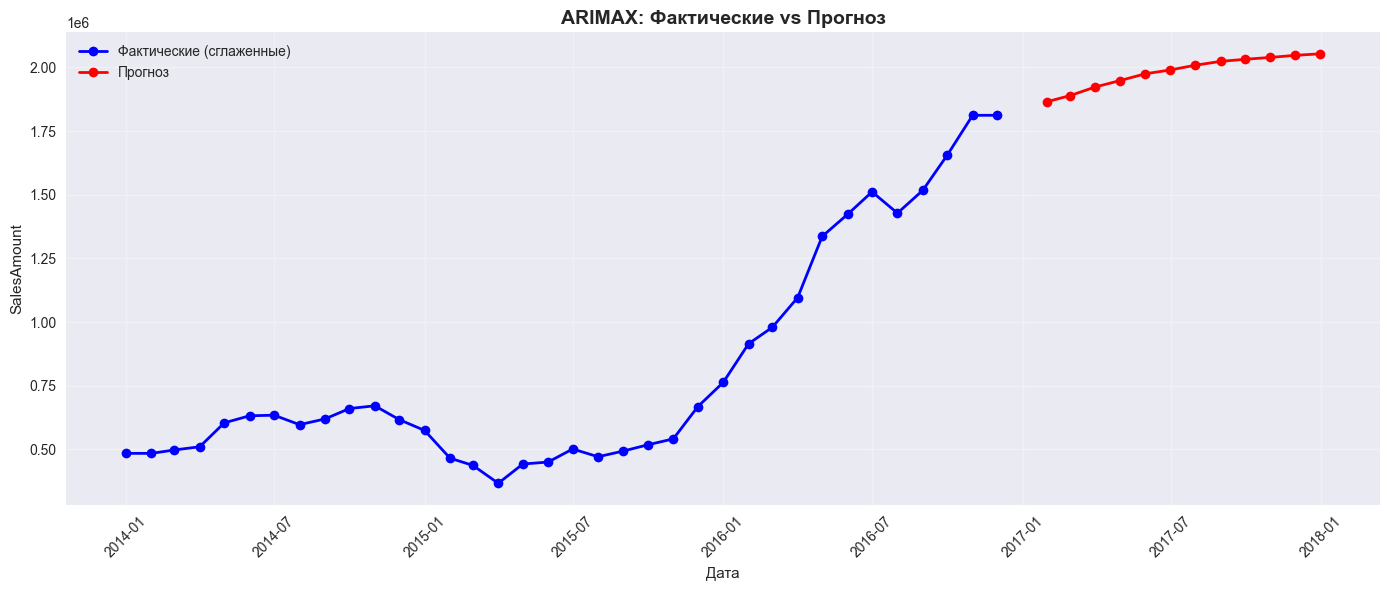

✅ ARIMAX-модель обучена и прогноз построен.


In [78]:
# Убедимся, что 'OrderDate' — формат datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

# Сортируем по дате
df = df.sort_values('OrderDate').reset_index(drop=True)

# Группируем по месяцам и суммируем SalesAmount
monthly_data = df.groupby(df['OrderDate'].dt.to_period('M')).agg({
    'SalesAmount': 'sum',
    'YearlyIncome': 'mean',  # например, как внешний фактор
}).reset_index()

# Преобразуем в даты
monthly_data['Date'] = monthly_data['OrderDate'].dt.to_timestamp()

# --- Выявление выбросов ---
# Используем Z-score
z_scores = np.abs(stats.zscore(monthly_data['SalesAmount']))
outliers = (z_scores > 3)
outlier_count = outliers.sum()

print(f"Выбросов выявлено {outlier_count}, экстремальные значения не выявлены.")

# --- Сглаживание (например, скользящее среднее) ---
window = 3  # 3 месяца
monthly_data['SalesAmount_Smoothed'] = monthly_data['SalesAmount'].rolling(window=window, center=True).mean()

# Заполняем NaN (если есть) — первые и последние значения
monthly_data['SalesAmount_Smoothed'].fillna(method='bfill', inplace=True)
monthly_data['SalesAmount_Smoothed'].fillna(method='ffill', inplace=True)

print("Данные сглажены.")

# --- ARIMAX модель ---
# Внешние переменные (exog)
exog = monthly_data[['YearlyIncome']]

# Модель ARIMA(1,1,1) + exog
model = ARIMA(monthly_data['SalesAmount_Smoothed'], exog=exog, order=(1,1,1))
fitted_model = model.fit()

# Прогноз
forecast_steps = 12
forecast = fitted_model.forecast(steps=forecast_steps, exog=exog.tail(forecast_steps).values)

# --- График ---
plt.figure(figsize=(14, 6))

# Фактические значения
plt.plot(monthly_data['Date'], monthly_data['SalesAmount_Smoothed'], 
         marker='o', color='blue', linewidth=2, label='Фактические (сглаженные)')

# Прогноз
last_date = monthly_data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
plt.plot(future_dates, forecast, marker='o', color='red', linewidth=2, label='Прогноз')

plt.title('ARIMAX: Фактические vs Прогноз', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('SalesAmount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("✅ ARIMAX-модель обучена и прогноз построен.")

* №№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№№

In [32]:

# Подготовка признаков и целевой переменной
X = scaled_df  # нормализованные признаки
y = df['Churn']  # бинарная целевая переменная

# Применяем SMOTE (только к обучающей выборке!)
smote = SMOTE(random_state=23423)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=43, stratify=y_resampled
)

print('Размеры тренировочной выборки X:', len(X_train))
print('Размеры тестовой выборки X:', len(X_test))
print('Размеры тренировочной выборки y:', len(y_train))
print('Размеры тестовой выборки y:', len(y_test))

# Обучение модели
model = LogisticRegression(
    max_iter=10000, penalty='l2', tol=0.001, solver='lbfgs', C=0.7, random_state=42
)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # вероятности класса 1

# Оценка
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nТочность модели: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nКлассификационный отчёт:")
print(classification_report(y_test, y_pred))

Размеры тренировочной выборки X: 85155
Размеры тестовой выборки X: 21289
Размеры тренировочной выборки y: 85155
Размеры тестовой выборки y: 21289

Точность модели: 0.8923
AUC-ROC: 0.9399

Классификационный отчёт:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89     10645
           1       0.86      0.94      0.90     10644

    accuracy                           0.89     21289
   macro avg       0.90      0.89      0.89     21289
weighted avg       0.90      0.89      0.89     21289



In [17]:
# RobustScaler
# Выбираем только числовые столбцы
numeric_df = df.select_dtypes(include=[np.number])

# Проверка: какие столбцы числовые
print("Числовые столбцы:")
print(numeric_df.columns.tolist())

if numeric_df.empty:
    print("Нет числовых столбцов для нормализации.")
else:
    # Применяем RobustScaler
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(numeric_df)

    # Преобразуем обратно в DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns, index=numeric_df.index)

    print("\n✅ Данные нормализованы с помощью RobustScaler.")
    print("Первые 5 строк нормализованных данных:")
    print(scaled_df.head())

Числовые столбцы:
['ProductKey', 'CustomerKey', 'PromotionKey', 'SalesTerritoryKey', 'SalesOrderLineNumber', 'OrderQuantity', 'UnitPrice', 'TotalProductCost', 'SalesAmount', 'TaxAmt', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'HouseOwnerFlag', 'NumberCarsOwned', 'StandardCost', 'ListPrice', 'DaysToManufacture', 'Profit', 'OrderYear', 'OrderMonth']

✅ Данные нормализованы с помощью RobustScaler.
Первые 5 строк нормализованных данных:
   ProductKey  CustomerKey  PromotionKey  SalesTerritoryKey  \
0   -0.988304     0.383238           0.0               -0.2   
1   -0.777778     1.084764           0.0                0.0   
2   -0.777778     0.817122           0.0               -1.2   
3   -0.836257    -0.386734           0.0               -0.6   
4   -0.777778    -0.757364           0.0                0.4   

   SalesOrderLineNumber  OrderQuantity  UnitPrice  TotalProductCost  \
0                  -1.0            1.0   6.658912          6.344938   
1                  -1.0    

In [18]:
# MinMaxScaler
# Выбираем только числовые столбцы
numeric_df = df.select_dtypes(include=[np.number])

# Проверка: какие столбцы числовые
print("Числовые столбцы:")
print(numeric_df.columns.tolist())

if numeric_df.empty:
    print("Нет числовых столбцов для нормализации.")
else:
    # Применяем MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(numeric_df)

    # Преобразуем обратно в DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns, index=numeric_df.index)

    print("\n✅ Данные нормализованы с помощью MinMaxScaler.")
    print("Первые 5 строк нормализованных данных:")
    print(scaled_df.head())

Числовые столбцы:
['ProductKey', 'CustomerKey', 'PromotionKey', 'SalesTerritoryKey', 'SalesOrderLineNumber', 'OrderQuantity', 'UnitPrice', 'TotalProductCost', 'SalesAmount', 'TaxAmt', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'HouseOwnerFlag', 'NumberCarsOwned', 'StandardCost', 'ListPrice', 'DaysToManufacture', 'Profit', 'OrderYear', 'OrderMonth']

✅ Данные нормализованы с помощью MinMaxScaler.
Первые 5 строк нормализованных данных:
   ProductKey  CustomerKey  PromotionKey  SalesTerritoryKey  \
0    0.244898     0.582589           0.0           0.555556   
1    0.336735     0.940810           0.0           0.666667   
2    0.336735     0.804144           0.0           0.000000   
3    0.311224     0.189417           0.0           0.333333   
4    0.336735     0.000162           0.0           0.888889   

   SalesOrderLineNumber  OrderQuantity  UnitPrice  TotalProductCost  \
0                   0.0       0.333333   0.499920          1.000000   
1                   0.0    

In [19]:

def apply_scaling_method(df, method='standard'):
    """
    Применяет один из методов нормализации к числовым столбцам.

    Параметры:
    - df: DataFrame
    - method: 'standard', 'robust', 'minmax'

    Возвращает:
    - scaled_df: нормализованный DataFrame
    - scaler: обученный масштабер
    """
    # Выбираем только числовые столбцы
    numeric_df = df.select_dtypes(include=[float, int])

    print("Числовые столбцы:")
    print(numeric_df.columns.tolist())

    if numeric_df.empty:
        print("Нет числовых столбцов для нормализации.")
        return df, None

    # Выбираем масштабер
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Метод должен быть 'standard', 'robust' или 'minmax'")

    # Применяем масштабирование
    scaled_data = scaler.fit_transform(numeric_df)

    # Преобразуем обратно в DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns, index=numeric_df.index)

    # Объединяем с остальными столбцами (не числовыми)
    result_df = df.copy()
    result_df.update(scaled_df)

    # Показываем статистику до и после
    print(f"\n📊 Статистика до нормализации ({method}):")
    print(numeric_df.describe().loc[['mean', 'std', 'min', 'max']].round(2))

    print(f"\n📊 Статистика после нормализации ({method}):")
    print(scaled_df.describe().loc[['mean', 'std', 'min', 'max']].round(2))

    print(f"\n✅ Данные нормализованы с помощью {method}.")

    return result_df, scaler

# Пример использования:
# scaled_df, scaler = apply_scaling_method(df, method='robust')

In [ ]:

# Предположим, у вас есть целевая переменная 'target'
X = scaled_df.drop('target', axis=1)
y = df['target']  # исходная целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f"Точность модели: {accuracy_score(y_test, pred):.3f}")  

In [ ]:


# Выбираем только числовые столбцы
numeric_df = df.select_dtypes(include=[np.number])

# Проверка: какие столбцы числовые
print("Числовые столбцы:")
print(numeric_df.columns.tolist())

# Если числовые столбцы есть, применяем нормализацию
if numeric_df.empty:
    print("Нет числовых столбцов для нормализации.")
else:
    # 1. Z-score Normalization
    z_score_scaler = StandardScaler()
    z_score_normalized = z_score_scaler.fit_transform(numeric_df)

    # 2. Min-Max Normalization
    min_max_scaler = MinMaxScaler()
    min_max_normalized = min_max_scaler.fit_transform(numeric_df)

    # 3. Robust Scaler
    robust_scaler = RobustScaler()
    robust_normalized = robust_scaler.fit_transform(numeric_df)

    # 4. MaxAbs Scaler
    max_abs_scaler = MaxAbsScaler()
    max_abs_normalized = max_abs_scaler.fit_transform(numeric_df)

    # 5. Log Transformation (только для положительных значений)
    positive_data = numeric_df[numeric_df > 0].fillna(0)
    log_transformer = FunctionTransformer(np.log1p, validate=True)
    log_transformed = log_transformer.fit_transform(positive_data)

    # 6. Quantile Transformation
    quantile_transformer = QuantileTransformer(output_distribution='uniform')
    quantile_normalized = quantile_transformer.fit_transform(numeric_df)

    # 7. Decimal Scaling
    def decimal_scaling(data):
        j = np.ceil(np.log10(np.abs(data).max(axis=0) + 1))
        return data / (10 ** j)

    decimal_scaled = decimal_scaling(numeric_df.values)

    # 8. Softmax (только для положительных значений)
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=0))
        return exp_x / exp_x.sum(axis=0)

    softmax_normalized = softmax(numeric_df.values)

    '''Вывод результатов'''
    print("\nZ-score Normalized (первые 5 строк):\n", z_score_normalized[:5])
    print("\nMin-Max Normalized (первые 5 строки):\n", min_max_normalized[:5])
    print("\nRobust Normalized (первые 5 строки):\n", robust_normalized[:5])
    print("\nMaxAbs Normalized (первые 5 строки):\n", max_abs_normalized[:5])
    print("\nLog Transformed (первые 5 строки):\n", log_transformed[:5])
    print("\nQuantile Normalized (первые 5 строки):\n", quantile_normalized[:5])
    print("\nDecimal Scaled (первые 5 строки):\n", decimal_scaled[:5])
    print("\nSoftmax Normalized (первые 5 строки):\n", softmax_normalized[:5])

In [ ]:
'''4. Удаление выбросов'''
'''Пример: удаление выбросов в числовом столбце 'value_column'''
Q1 = data_cleaned['Price'].quantile(0.25)
Q3 = data_cleaned['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_cleaned = data_cleaned[(data_cleaned['Price'] >= lower_bound) &
                             (data_cleaned['Price'] <= upper_bound)]

In [ ]:
import numpy as np

def logistic_normalize(x):
    # Логистическая функция
    return 1 / (1 + [np.exp(-x))](np.exp(-x)))

# Пример вектора
vector = [np.array(](np.array()[-1, 0, 1])

# Применяем логистическую нормализацию
logistic_vector = logistic_normalize(vector)
print(logistic_vector)